In [1]:
import jax
import jax.nn as jnn
import jax.numpy as jnp
import numpy as np

import equinox as eqx
import optax
import matplotlib.pyplot as plt
from exciting_environments.pmsm.pmsm_env import PMSM

2025-02-18 15:56:22.866324: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.77). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
import os
os.chdir("..")
from policy.policy_training import DPCTrainer
from models.models import NeuralEulerODE,MLP

In [3]:
gpus = jax.devices()
jax.config.update("jax_default_device", gpus[0])

In [4]:
motor_env = PMSM(
    saturated=True,
    LUT_motor_name="BRUSA",
    batch_size=1,
    control_state=[], 
    static_params = {
            "p": 3,
            "r_s": 15e-3,
            "l_d": 0.37e-3,
            "l_q": 1.2e-3,
            "psi_p": 65.6e-3,
            "deadtime": 0,
    })

Reset function to get random initial_observation for training of the dpc - using pmsm_env reset for random init:

In [5]:
@eqx.filter_jit
def reset(node,rng):
    obs, _ = motor_env.reset(motor_env.env_properties, rng) 
    obs = obs.at[2].set((3*1500 / 60 * 2 * jnp.pi) / (2 * jnp.pi * 3 * 11000 / 60))
    return obs

Function returns random initial_observation and reference_observation the dpc should target while training:

In [6]:
@eqx.filter_jit
def dat_gen_sin(node, rng, traj_len):
    rng, subkey = jax.random.split(rng)
    ref_obs = reset(node,subkey) 
    rng, subkey = jax.random.split(rng)
    init_obs = reset(node,subkey)  
    return init_obs, ref_obs, rng

Featurize function for the dpc policy - feat_obs is input of the dpc_policy network:

In [7]:
@eqx.filter_jit
def featurize(obs,ref_obs, featurize_state=jnp.array([0,0])):
    feat_obs=jnp.concatenate([obs[0:2],ref_obs[0:2],ref_obs[0:2]-obs[0:2],featurize_state])
    featurize_state=jnp.clip(featurize_state + ref_obs[0:2]-obs[0:2],min=-1,max=1) * (jnp.sign(0.01-jnp.sum((ref_obs[0:2]-obs[0:2])**2))*0.5+0.5)
    return feat_obs,featurize_state

Loss for reference tracking:

In [8]:
@eqx.filter_jit
def mse_loss(feat_obs):
    loss=jnp.mean(jnp.sum((feat_obs[:,4:6])**2,axis=1))#be aware of idx if changing featurize
    return loss

Soft constraints:

In [9]:
@eqx.filter_jit
def penalty_loss(feat_obs):
    i_d=feat_obs[:,0]*0.5-0.5
    i_q=feat_obs[:,1]
    penalties = jnp.sum(jax.nn.relu(i_d**2+i_q**2-1))
    return penalties

Initialize dpc-policy:

In [10]:
jax_key = jax.random.PRNGKey(2)
policy=MLP([8,64,64,64,2],key=jax_key)
optimizer = optax.adam(5e-4)
opt_state = optimizer.init(policy)

Design training structure:

In [11]:
data_batch_size=100
trainer=DPCTrainer(
    batch_size=data_batch_size,
    train_steps=10000,
    horizon_length=20,
    data_gen_sin=dat_gen_sin,
    featurize=featurize,
    policy_optimizer=optimizer,
    ref_loss=mse_loss,
    constr_penalty=penalty_loss,
    ref_loss_weight=1)
keys=jax.vmap(jax.random.PRNGKey)(np.random.randint(0, 2**31, size=(data_batch_size,)))
#key=jax.vmap(jax.random.PRNGKey)(jnp.linspace(0,1000,1001).astype(int))

In [12]:
def featurize_node(obs):
    return obs[:2]  # jnp.concatenate([obs[0:2],obs[4:5],obs[5:6]])

### 1.Example: DPC Training on Node

Get Node trained with DMPE Data (Notebook 2.0.3):

In [13]:
jax_key = jax.random.PRNGKey(2)
node_struct=NeuralEulerODE([4,128,128,128,128,2],key=jax_key)
node = eqx.tree_deserialise_leaves("final_models/black_box/Model_4_128_1.eqx", node_struct)

100%|██████████| 10000/10000 [01:27<00:00, 113.71it/s]


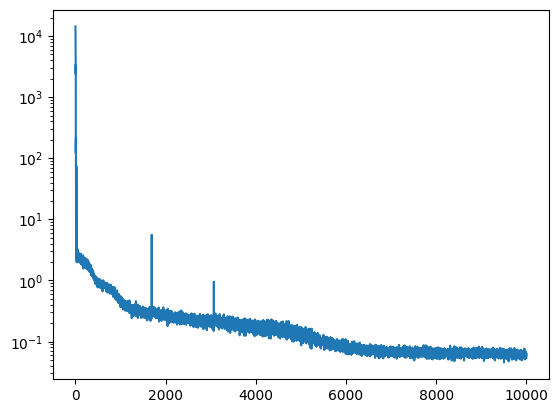

In [14]:
fin_policy_1,fin_opt_state,fin_keys,losses, val_losses=trainer.fit_on_node(policy, node, motor_env.tau, featurize_node, keys, opt_state, validate_every=100)
plt.plot(losses)
plt.yscale('log')

### 2.Example: DPC Training on pmsm_env

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [04:00<00:00, 41.58it/s]


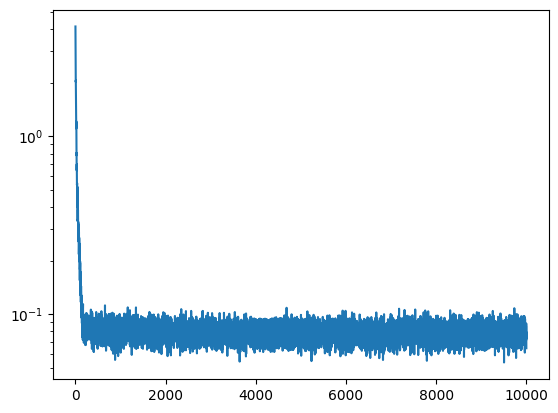

In [15]:
fin_policy_env,fin_opt_state2,fin_keys2,losses2, val_losses=trainer.fit_on_env(policy,motor_env,keys,opt_state)
plt.plot(losses2)
plt.yscale('log')

## Evaluate on pmsm_env (motor_env):

In [16]:
from utils.evaluation import steps_eval

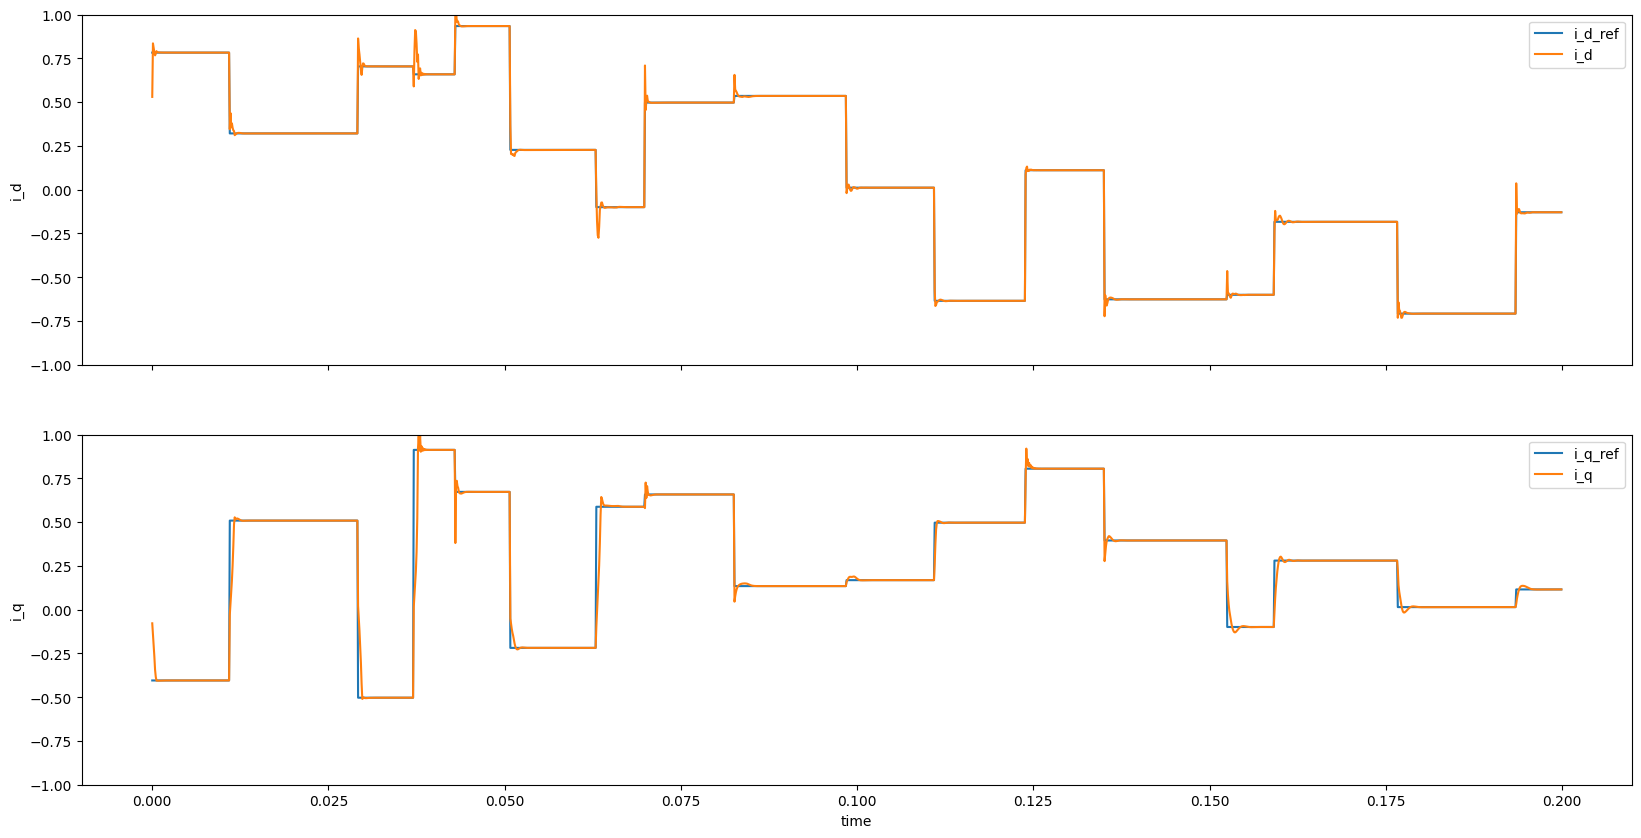

In [17]:
obs,obs_ref,acts=steps_eval(motor_env,reset,fin_policy_1,featurize,jax.random.PRNGKey(2),2000)

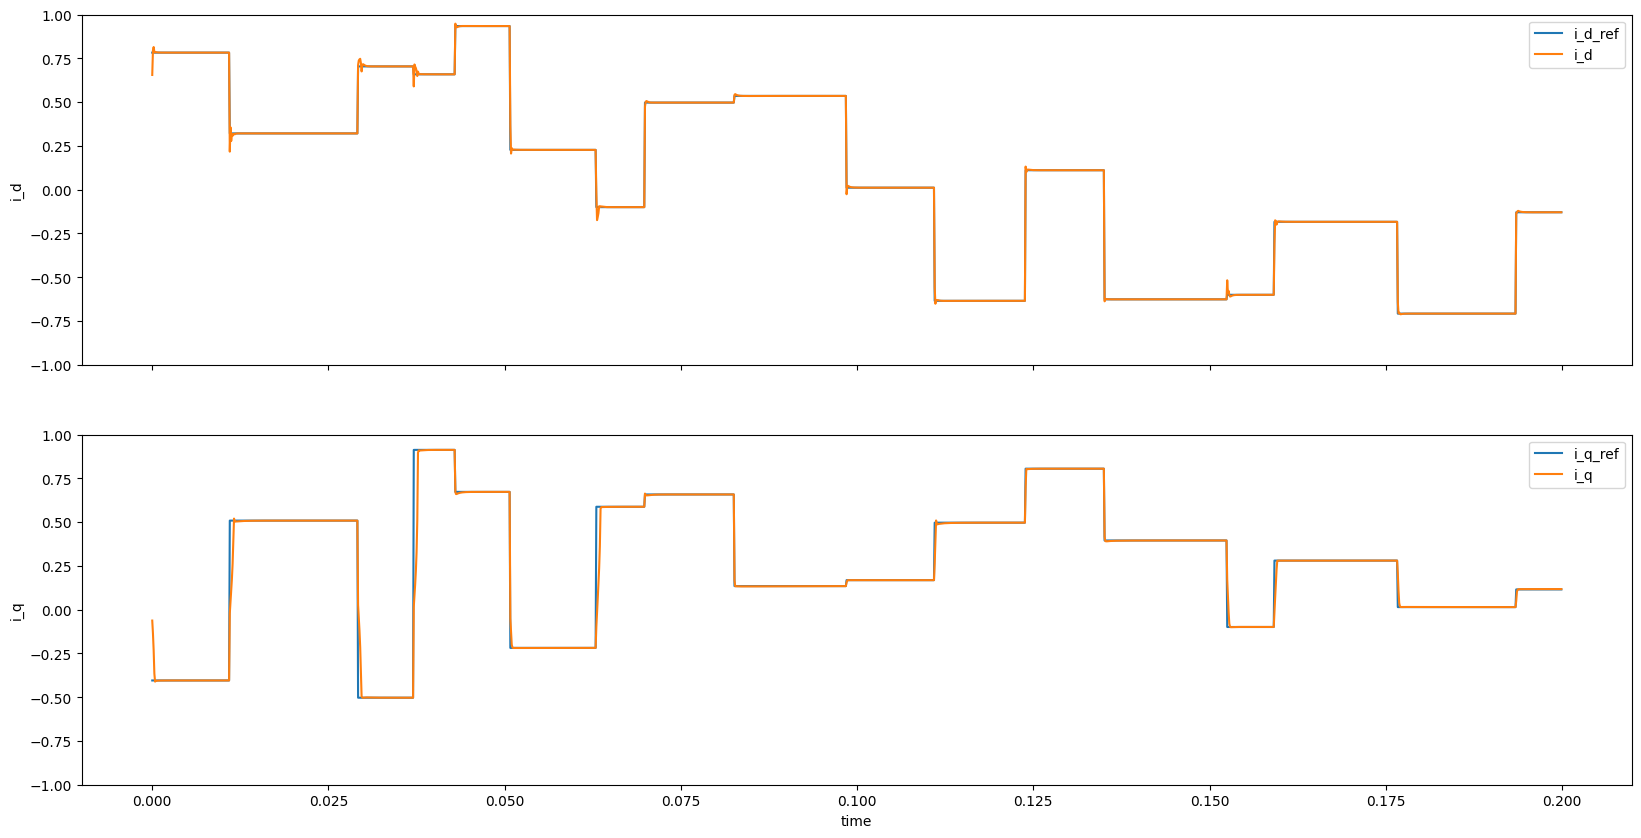

In [18]:
obs,obs_ref,acts=steps_eval(motor_env,reset,fin_policy_env,featurize,jax.random.PRNGKey(2),2000)